### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import nltk
import spacy
from nltk.corpus import stopwords
import re

In [2]:
el_df = pd.read_csv('data/elonmusk.csv')
el_df.head()

,Datetime,Tweet Id,Text,Username
0,2021-04-11 15:50:33+00:00,1381273474400800773,@vincent13031925 For now. Costs are decreasing...,elonmusk
1,2021-04-11 15:48:58+00:00,1381273076709478403,Love this beautiful shot,elonmusk
2,2021-04-11 14:49:38+00:00,1381258144916008964,@agnostoxxx @CathieDWood @ARKInvest Trust the ...,elonmusk
3,2021-04-11 12:23:49+00:00,1381221447322935303,The art In Cyberpunk is incredible,elonmusk
4,2021-04-11 06:18:47+00:00,1381129584435818496,@itsALLrisky 🤣🤣,elonmusk


In [3]:
spx_df = pd.read_csv('data/spacex.csv')
spx_df.head()

,Datetime,Tweet Id,Text,Username
0,2021-04-07 17:39:47+00:00,1379851411840593925,Deployment of 60 Starlink satellites confirmed...,SpaceX
1,2021-04-07 16:43:55+00:00,1379837350977540101,Falcon 9’s first stage has landed on the Of Co...,SpaceX
2,2021-04-07 16:36:01+00:00,1379835363963727875,Liftoff! https://t.co/luuYBpfcaw,SpaceX
3,2021-04-07 16:20:52+00:00,1379831553191079940,Watch Falcon 9 launch 60 Starlink satellites t...,SpaceX
4,2021-04-07 16:06:56+00:00,1379828046333505536,T-30 minutes until launch of Starlink; Falcon ...,SpaceX


In [4]:
tsl_df = pd.read_csv('data/tesla.csv')
tsl_df.head()

,Datetime,Tweet Id,Text,Username
0,2021-04-05 23:11:12+00:00,1379210038141665281,Tesla seats factory https://t.co/X4PLPjuuj4,Tesla
1,2021-04-01 13:45:40+00:00,1377618168705859585,Model 3 deliveries in Europe https://t.co/fiBN...,Tesla
2,2021-03-25 16:12:35+00:00,1375118425362628613,"6,000+ Superchargers across Europe — at 600 lo...",Tesla
3,2021-03-16 18:04:04+00:00,1371884988371771399,Backseat views from Model Y\n\n📸 by loghi007 o...,Tesla
4,2021-03-14 15:47:19+00:00,1371125797671538688,Semi on the track https://t.co/0QCTYGbLJv,Tesla


# Elon Musk's Tweets
### Word segmentation

In [5]:
#decontract to not create token from special cases.
#For example, "won't" or " can't" can generate tokens as "wo", "ca" which are not removed by stopwords

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#convert to lower case when counting frequencies
el_df['text_lower'] = el_df['Text'].str.lower()
el_df['text_decont'] = el_df['text_lower'].apply(lambda x: decontracted(x))
#remove punctuation
el_df['text_no_punc'] = el_df['text_decont'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

el_df.head()

,Datetime,Tweet Id,Text,Username,text_lower,text_decont,text_no_punc
0,2021-04-11 15:50:33+00:00,1381273474400800773,@vincent13031925 For now. Costs are decreasing...,elonmusk,@vincent13031925 for now. costs are decreasing...,@vincent13031925 for now. costs are decreasing...,vincent13031925 for now costs are decreasing...
1,2021-04-11 15:48:58+00:00,1381273076709478403,Love this beautiful shot,elonmusk,love this beautiful shot,love this beautiful shot,love this beautiful shot
2,2021-04-11 14:49:38+00:00,1381258144916008964,@agnostoxxx @CathieDWood @ARKInvest Trust the ...,elonmusk,@agnostoxxx @cathiedwood @arkinvest trust the ...,@agnostoxxx @cathiedwood @arkinvest trust the ...,agnostoxxx cathiedwood arkinvest trust the ...
3,2021-04-11 12:23:49+00:00,1381221447322935303,The art In Cyberpunk is incredible,elonmusk,the art in cyberpunk is incredible,the art in cyberpunk is incredible,the art in cyberpunk is incredible
4,2021-04-11 06:18:47+00:00,1381129584435818496,@itsALLrisky 🤣🤣,elonmusk,@itsallrisky 🤣🤣,@itsallrisky 🤣🤣,itsallrisky


In [6]:
#tokenize
# keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
stopwords = set(stopwords.words('english'))
stopwords.add('amp')
stopwords.add('https')
stopwords.add('http')
stopwords.add('co')

el_df['lemm_tk'] = el_df['text_no_punc'].apply(lambda x: [word.lemma_ for word in nlp(x)])
el_df['filter_tk'] = el_df['lemm_tk'].apply(lambda x: [word for word in x if not word in stopwords
                                                                  and word.isalpha()])
#the last filter is to remove number because number standing alone maybe make no sense

In [7]:
el_df

,Datetime,Tweet Id,Text,Username,text_lower,text_decont,text_no_punc,lemm_tk,filter_tk
0,2021-04-11 15:50:33+00:00,1381273474400800773,@vincent13031925 For now. Costs are decreasing...,elonmusk,@vincent13031925 for now. costs are decreasing...,@vincent13031925 for now. costs are decreasing...,vincent13031925 for now costs are decreasing...,"[ , vincent13031925, for, now, , cost, be, de...","[cost, decrease, rapidly]"
1,2021-04-11 15:48:58+00:00,1381273076709478403,Love this beautiful shot,elonmusk,love this beautiful shot,love this beautiful shot,love this beautiful shot,"[love, this, beautiful, shot]","[love, beautiful, shot]"
2,2021-04-11 14:49:38+00:00,1381258144916008964,@agnostoxxx @CathieDWood @ARKInvest Trust the ...,elonmusk,@agnostoxxx @cathiedwood @arkinvest trust the ...,@agnostoxxx @cathiedwood @arkinvest trust the ...,agnostoxxx cathiedwood arkinvest trust the ...,"[ , agnostoxxx, , cathiedwood, , arkinv, tru...","[agnostoxxx, cathiedwood, arkinv, trust, shrub]"
3,2021-04-11 12:23:49+00:00,1381221447322935303,The art In Cyberpunk is incredible,elonmusk,the art in cyberpunk is incredible,the art in cyberpunk is incredible,the art in cyberpunk is incredible,"[the, art, in, cyberpunk, be, incredible]","[art, cyberpunk, incredible]"
4,2021-04-11 06:18:47+00:00,1381129584435818496,@itsALLrisky 🤣🤣,elonmusk,@itsallrisky 🤣🤣,@itsallrisky 🤣🤣,itsallrisky,"[ , itsallrisky, ]",[itsallrisky]
...,...,...,...,...,...,...,...,...,...
12503,2011-12-03 08:22:07+00:00,142881284019060736,That was a total non sequitur btw,elonmusk,that was a total non sequitur btw,that was a total non sequitur btw,that was a total non sequitur btw,"[that, be, a, total, non, sequitur, btw]","[total, non, sequitur, btw]"
12504,2011-12-03 08:20:28+00:00,142880871391838208,"Great Voltaire quote, arguably better than Twa...",elonmusk,"great voltaire quote, arguably better than twa...","great voltaire quote, arguably better than twa...",great voltaire quote arguably better than twa...,"[great, voltaire, quote, , arguably, well, th...","[great, voltaire, quote, arguably, well, twain..."
12505,2011-12-01 10:29:04+00:00,142188458125963264,I made the volume on the Model S http://t.co/w...,elonmusk,i made the volume on the model s http://t.co/w...,i made the volume on the model s http://t.co/w...,i made the volume on the model s http t co w...,"[I, make, the, volume, on, the, model, s, http...","[I, make, volume, model, go, I, need, work, mi..."
12506,2011-12-01 09:55:11+00:00,142179928203460608,Went to Iceland on Sat to ride bumper cars on ...,elonmusk,went to iceland on sat to ride bumper cars on ...,went to iceland on sat to ride bumper cars on ...,went to iceland on sat to ride bumper cars on ...,"[go, to, iceland, on, sit, to, ride, bumper, c...","[go, iceland, sit, ride, bumper, car, ice, cou..."


I use spacy tokenizer to segment words because spacy tokenizer includes stemming with results being better than that of combining nltk tokenizer and nltk Porter/Snowball stemming techniques.

### Calculate the frequency

In [8]:
#create bag words
all_vid =[]
for item in el_df.filter_tk.to_numpy():
    all_vid += item    
bag_words = list(set(all_vid))
np.shape(bag_words)

(13147,)

In [9]:
bag_words[:10]

['augmentation',
 'none',
 'initiative',
 'chief',
 'improbability',
 'tsla',
 'munter',
 'improbabletoad',
 'word',
 'broadly']

In [10]:
# declare "bag_words_frequency" as dictionary
bag_words_frequency={} 
for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

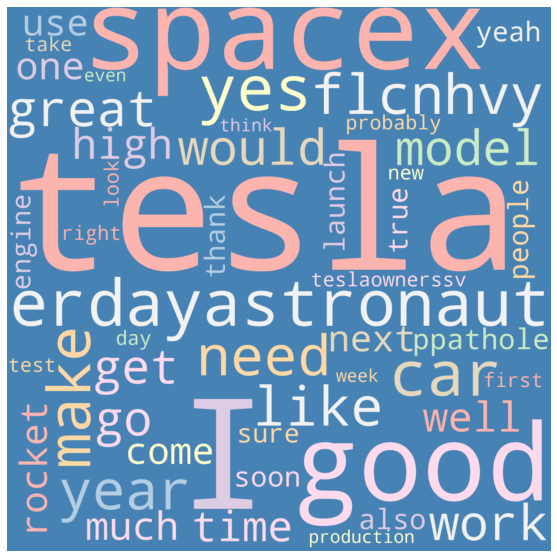

In [11]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               ,collocations=False, stopwords = STOPWORDS
               ,max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/elon_musk_overall.png", bbox_inches='tight', dpi=600)
plt.show()

## 1st period

In [12]:
el1 = el_df[el_df.Datetime >= '2020-02-19'][el_df.Datetime < '2020-04-18']
el1.shape

<ipython-input-12-bf633f19f91c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  el1 = el_df[el_df.Datetime >= '2020-02-19'][el_df.Datetime < '2020-04-18']


(506, 9)

### Calculate the frequency

In [13]:
#create bag words
all_vid =[]

for item in el1.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(1626,)

In [14]:
bag_words[:10]

['elderly',
 'austin',
 'reusable',
 'word',
 'ink',
 'committee',
 'study',
 'goal',
 'taxis',
 'dramatically']

In [15]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

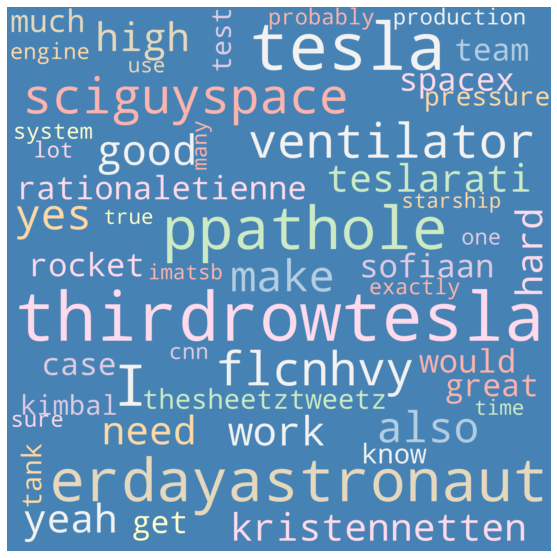

In [16]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/elon_musk_1st.png", bbox_inches='tight', dpi=600)
plt.show()

## 2nd period

In [17]:
el2 = el_df[el_df.Datetime >= '2020-09-02'][el_df.Datetime < '2020-10-13']
el2.shape

<ipython-input-17-51367df82d41>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  el2 = el_df[el_df.Datetime >= '2020-09-02'][el_df.Datetime < '2020-10-13']


(352, 9)

### Calculate the frequency

In [18]:
#create bag words
all_vid =[]

for item in el2.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(1477,)

In [19]:
bag_words[:10]

['none',
 'crush',
 'word',
 'spreadsheet',
 'wintonark',
 'goal',
 'tonnage',
 'telephoto',
 'uotvmkgxqh',
 'dramatically']

In [20]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

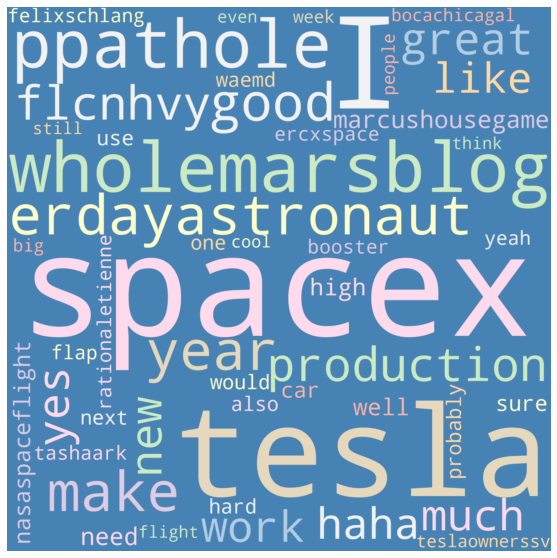

In [21]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/elon_musk_2nd.png", bbox_inches='tight', dpi=600)
plt.show()

# Tesla's Tweets
### Word segmentation

In [22]:
#convert to lower case when counting frequencies
tsl_df['text_lower'] = tsl_df['Text'].str.lower()

In [23]:
#decontract to not create token from special cases.
#For example, "won't" or " can't" can generate tokens as "wo", "ca" which are not removed by stopwords

import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

tsl_df['text_decont'] = tsl_df['text_lower'].apply(lambda x: decontracted(x))
tsl_df.head()

,Datetime,Tweet Id,Text,Username,text_lower,text_decont
0,2021-04-05 23:11:12+00:00,1379210038141665281,Tesla seats factory https://t.co/X4PLPjuuj4,Tesla,tesla seats factory https://t.co/x4plpjuuj4,tesla seats factory https://t.co/x4plpjuuj4
1,2021-04-01 13:45:40+00:00,1377618168705859585,Model 3 deliveries in Europe https://t.co/fiBN...,Tesla,model 3 deliveries in europe https://t.co/fibn...,model 3 deliveries in europe https://t.co/fibn...
2,2021-03-25 16:12:35+00:00,1375118425362628613,"6,000+ Superchargers across Europe — at 600 lo...",Tesla,"6,000+ superchargers across europe — at 600 lo...","6,000+ superchargers across europe — at 600 lo..."
3,2021-03-16 18:04:04+00:00,1371884988371771399,Backseat views from Model Y\n\n📸 by loghi007 o...,Tesla,backseat views from model y\n\n📸 by loghi007 o...,backseat views from model y\n\n📸 by loghi007 o...
4,2021-03-14 15:47:19+00:00,1371125797671538688,Semi on the track https://t.co/0QCTYGbLJv,Tesla,semi on the track https://t.co/0qctygbljv,semi on the track https://t.co/0qctygbljv


In [24]:
#tokenize
# keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
#stopwords = set(stopwords.words('english'))
stopwords.add('amp')
stopwords.add('https')
stopwords.add('http')
stopwords.add('co')

#remove punctuation
tsl_df['text_no_punc'] = tsl_df['text_decont'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
tsl_df['lemm_tk'] = tsl_df['text_no_punc'].apply(lambda x: [word.lemma_ for word in nlp(x)])
tsl_df['filter_tk'] = tsl_df['lemm_tk'].apply(lambda x: [word for word in x
                                                                  if not word in stopwords
                                                                  and word.isalpha()])
#the last filter is to remove number because number standing alone maybe make no sense

In [25]:
tsl_df

,Datetime,Tweet Id,Text,Username,text_lower,text_decont,text_no_punc,lemm_tk,filter_tk
0,2021-04-05 23:11:12+00:00,1379210038141665281,Tesla seats factory https://t.co/X4PLPjuuj4,Tesla,tesla seats factory https://t.co/x4plpjuuj4,tesla seats factory https://t.co/x4plpjuuj4,tesla seats factory https t co x4plpjuuj4,"[tesla, seat, factory, https, , t, co, x4plp...","[tesla, seat, factory]"
1,2021-04-01 13:45:40+00:00,1377618168705859585,Model 3 deliveries in Europe https://t.co/fiBN...,Tesla,model 3 deliveries in europe https://t.co/fibn...,model 3 deliveries in europe https://t.co/fibn...,model 3 deliveries in europe https t co fibn...,"[model, 3, delivery, in, europe, https, , t,...","[model, delivery, europe]"
2,2021-03-25 16:12:35+00:00,1375118425362628613,"6,000+ Superchargers across Europe — at 600 lo...",Tesla,"6,000+ superchargers across europe — at 600 lo...","6,000+ superchargers across europe — at 600 lo...",6 000 superchargers across europe at 600 lo...,"[6, 000, , supercharger, across, europe, , ...","[supercharger, across, europe, location, count..."
3,2021-03-16 18:04:04+00:00,1371884988371771399,Backseat views from Model Y\n\n📸 by loghi007 o...,Tesla,backseat views from model y\n\n📸 by loghi007 o...,backseat views from model y\n\n📸 by loghi007 o...,backseat views from model y\n\n by loghi007 o...,"[backseat, view, from, model, y, \n\n , by, l...","[backseat, view, model, instagram]"
4,2021-03-14 15:47:19+00:00,1371125797671538688,Semi on the track https://t.co/0QCTYGbLJv,Tesla,semi on the track https://t.co/0qctygbljv,semi on the track https://t.co/0qctygbljv,semi on the track https t co 0qctygbljv,"[semi, on, the, track, https, , t, co, 0qcty...","[semi, track]"
...,...,...,...,...,...,...,...,...,...
7216,2008-02-13 15:45:06+00:00,707894482,Facebook ad experiment proved what I read in t...,Tesla,facebook ad experiment proved what i read in t...,facebook ad experiment proved what i read in t...,facebook ad experiment proved what i read in t...,"[facebook, ad, experiment, prove, what, I, rea...","[facebook, ad, experiment, prove, I, read, art..."
7217,2008-02-12 04:41:46+00:00,702283732,edmunds review - overall positive although som...,Tesla,edmunds review - overall positive although som...,edmunds review - overall positive although som...,edmunds review overall positive although som...,"[edmund, review, , overall, positive, althou...","[edmund, review, overall, positive, although, ..."
7218,2008-02-12 01:52:14+00:00,701810442,discussing future plans for VP10,Tesla,discussing future plans for vp10,discussing future plans for vp10,discussing future plans for vp10,"[discuss, future, plan, for, vp10]","[discuss, future, plan]"
7219,2008-02-10 20:24:26+00:00,697069922,just placed facebook ad to see how that works...,Tesla,just placed facebook ad to see how that works...,just placed facebook ad to see how that works...,just placed facebook ad to see how that works...,"[just, place, , facebook, ad, to, see, how, t...","[place, facebook, ad, see, work, I, guess, I, ..."


I use spacy tokenizer to segment words because spacy tokenizer includes stemming with results being better than that of combining nltk tokenizer and nltk Porter/Snowball stemming techniques.

### Calculate the frequency

In [26]:
#create bag words
all_vid =[]

for item in tsl_df.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(9819,)

In [27]:
bag_words[:10]

['iamthechuster',
 'lwbikjdi',
 'ana',
 'initiative',
 'chief',
 'schmidto',
 'tsla',
 'craigxtodd',
 'loverboyband',
 'word']

In [28]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

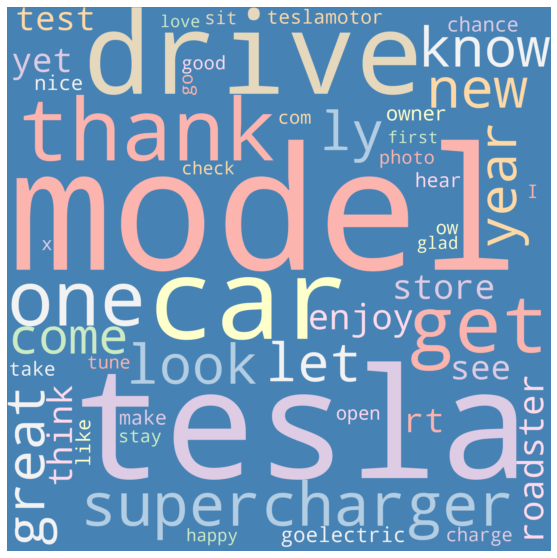

In [29]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/tesla_overall.png", bbox_inches='tight', dpi=600)
plt.show()

## 1st period

In [30]:
tsl1 = tsl_df[tsl_df.Datetime >= '2020-02-19'][tsl_df.Datetime < '2020-04-18']
tsl1.shape

<ipython-input-30-ff4cd7892bfa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tsl1 = tsl_df[tsl_df.Datetime >= '2020-02-19'][tsl_df.Datetime < '2020-04-18']


(8, 9)

### Calculate the frequency

In [31]:
#create bag words
all_vid =[]

for item in tsl1.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(61,)

In [32]:
bag_words[:10]

['week',
 'supply',
 'home',
 'good',
 'track',
 'handling',
 'roof',
 'book',
 'york',
 'safety']

In [33]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

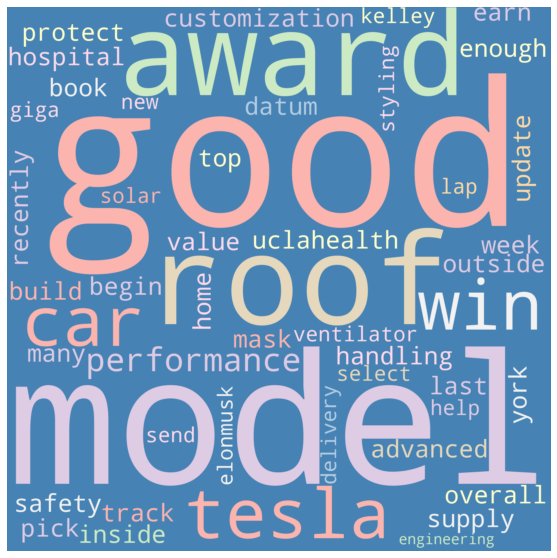

In [34]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/tesla_1st.png", bbox_inches='tight', dpi=600)
plt.show()

## 2nd period

In [35]:
tsl2 = tsl_df[tsl_df.Datetime >= '2020-09-02'][tsl_df.Datetime < '2020-10-13']
tsl2.shape

<ipython-input-35-3c8c37eb9482>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tsl2 = tsl_df[tsl_df.Datetime >= '2020-09-02'][tsl_df.Datetime < '2020-10-13']


(3, 9)

### Calculate the frequency

In [36]:
#create bag words
all_vid =[]

for item in tsl2.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(16,)

In [37]:
bag_words[:10]

['car',
 'sunday',
 'rwqdbfcwoh',
 'battery',
 'start',
 'run',
 'plaid',
 'laguna',
 'thing',
 'model']

In [38]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

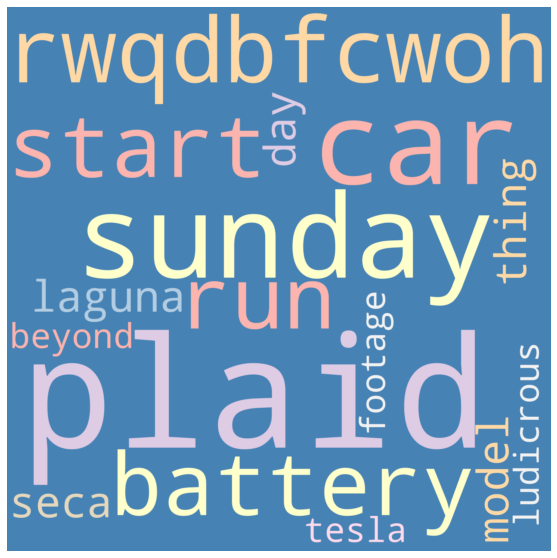

In [39]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/tesla_2nd.png", bbox_inches='tight', dpi=600)
plt.show()

# SpaceX's Tweets
### Word segmentation

In [40]:
#convert to lower case when counting frequencies
spx_df['text_lower'] = spx_df['Text'].str.lower()

In [41]:
#decontract to not create token from special cases.
#For example, "won't" or " can't" can generate tokens as "wo", "ca" which are not removed by stopwords

import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

spx_df['text_decont'] = spx_df['text_lower'].apply(lambda x: decontracted(x))
spx_df.head()

,Datetime,Tweet Id,Text,Username,text_lower,text_decont
0,2021-04-07 17:39:47+00:00,1379851411840593925,Deployment of 60 Starlink satellites confirmed...,SpaceX,deployment of 60 starlink satellites confirmed...,deployment of 60 starlink satellites confirmed...
1,2021-04-07 16:43:55+00:00,1379837350977540101,Falcon 9’s first stage has landed on the Of Co...,SpaceX,falcon 9’s first stage has landed on the of co...,falcon 9’s first stage has landed on the of co...
2,2021-04-07 16:36:01+00:00,1379835363963727875,Liftoff! https://t.co/luuYBpfcaw,SpaceX,liftoff! https://t.co/luuybpfcaw,liftoff! https://t.co/luuybpfcaw
3,2021-04-07 16:20:52+00:00,1379831553191079940,Watch Falcon 9 launch 60 Starlink satellites t...,SpaceX,watch falcon 9 launch 60 starlink satellites t...,watch falcon 9 launch 60 starlink satellites t...
4,2021-04-07 16:06:56+00:00,1379828046333505536,T-30 minutes until launch of Starlink; Falcon ...,SpaceX,t-30 minutes until launch of starlink; falcon ...,t-30 minutes until launch of starlink; falcon ...


In [42]:
#tokenize
#remove punctuation
spx_df['text_no_punc'] = spx_df['text_decont'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
spx_df['lemm_tk'] = spx_df['text_no_punc'].apply(lambda x: [word.lemma_ for word in nlp(x)])
spx_df['filter_tk'] = spx_df['lemm_tk'].apply(lambda x: [word for word in x
                                                                  if not word in stopwords
                                                                  and word.isalpha()])
#the last filter is to remove number because number standing alone maybe make no sense

In [43]:
spx_df

,Datetime,Tweet Id,Text,Username,text_lower,text_decont,text_no_punc,lemm_tk,filter_tk
0,2021-04-07 17:39:47+00:00,1379851411840593925,Deployment of 60 Starlink satellites confirmed...,SpaceX,deployment of 60 starlink satellites confirmed...,deployment of 60 starlink satellites confirmed...,deployment of 60 starlink satellites confirmed...,"[deployment, of, 60, starlink, satellite, conf...","[deployment, starlink, satellite, confirm, com..."
1,2021-04-07 16:43:55+00:00,1379837350977540101,Falcon 9’s first stage has landed on the Of Co...,SpaceX,falcon 9’s first stage has landed on the of co...,falcon 9’s first stage has landed on the of co...,falcon 9 s first stage has landed on the of co...,"[falcon, 9, s, first, stage, have, land, on, t...","[falcon, first, stage, land, course, I, still,..."
2,2021-04-07 16:36:01+00:00,1379835363963727875,Liftoff! https://t.co/luuYBpfcaw,SpaceX,liftoff! https://t.co/luuybpfcaw,liftoff! https://t.co/luuybpfcaw,liftoff https t co luuybpfcaw,"[liftoff, , https, , t, co, luuybpfcaw]","[liftoff, luuybpfcaw]"
3,2021-04-07 16:20:52+00:00,1379831553191079940,Watch Falcon 9 launch 60 Starlink satellites t...,SpaceX,watch falcon 9 launch 60 starlink satellites t...,watch falcon 9 launch 60 starlink satellites t...,watch falcon 9 launch 60 starlink satellites t...,"[watch, falcon, 9, launch, 60, starlink, satel...","[watch, falcon, launch, starlink, satellite, o..."
4,2021-04-07 16:06:56+00:00,1379828046333505536,T-30 minutes until launch of Starlink; Falcon ...,SpaceX,t-30 minutes until launch of starlink; falcon ...,t-30 minutes until launch of starlink; falcon ...,t 30 minutes until launch of starlink falcon ...,"[t, 30, minute, until, launch, of, starlink, ...","[minute, launch, starlink, falcon, weather, lo..."
...,...,...,...,...,...,...,...,...,...
4142,2009-05-11 16:32:48+00:00,1764447928,Good Luck to STS-125!,SpaceX,good luck to sts-125!,good luck to sts-125!,good luck to sts 125,"[good, luck, to, sts, 125]","[good, luck, sts]"
4143,2009-04-30 15:02:35+00:00,1659601384,@ElonMusk Elon Musk does not have a Twitter ac...,SpaceX,@elonmusk elon musk does not have a twitter ac...,@elonmusk elon musk does not have a twitter ac...,elonmusk elon musk does not have a twitter ac...,"[ , elonmusk, elon, musk, do, not, have, a, tw...","[elonmusk, elon, musk, twitter, account, pleas..."
4144,2009-04-30 14:59:57+00:00,1659576083,"Elon Musk does not have a Twitter account, any...",SpaceX,"elon musk does not have a twitter account, any...","elon musk does not have a twitter account, any...",elon musk does not have a twitter account any...,"[elon, musk, do, not, have, a, twitter, accoun...","[elon, musk, twitter, account, anyone, claim, ..."
4145,2009-04-29 16:16:14+00:00,1650131761,http://tinyurl.com/d9hsl3,SpaceX,http://tinyurl.com/d9hsl3,http://tinyurl.com/d9hsl3,http tinyurl com d9hsl3,"[http, , tinyurl, com, d9hsl3]","[tinyurl, com]"


### Calculate the frequency

In [44]:
#create bag words
all_vid =[]

for item in spx_df.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(4091,)

In [45]:
bag_words[:10]

['metaphysicalmilkshake',
 'grapple',
 'wonderful',
 'maj',
 'initiative',
 'nssl',
 'crush',
 'memorial',
 'discontinue',
 'chief']

In [46]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

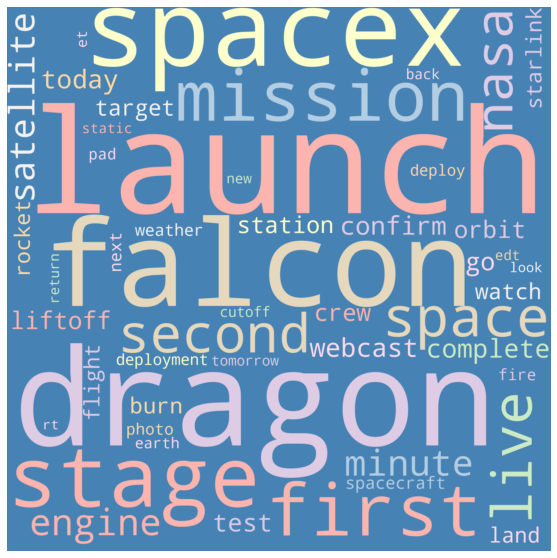

In [47]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/space_x_overall.png", bbox_inches='tight', dpi=600)
plt.show()

## 1st period

In [48]:
spx1 = spx_df[spx_df.Datetime >= '2020-02-19'][spx_df.Datetime < '2020-04-18']
spx1.shape

<ipython-input-48-54082b4bfb3c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spx1 = spx_df[spx_df.Datetime >= '2020-02-19'][spx_df.Datetime < '2020-04-18']


(42, 9)

### Calculate the frequency

In [49]:
#create bag words
all_vid =[]

for item in spx1.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(236,)

In [50]:
bag_words[:10]

['commercial',
 'asteroid',
 'supply',
 'mar',
 'water',
 'formation',
 'late',
 'back',
 'burn',
 'march']

In [51]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

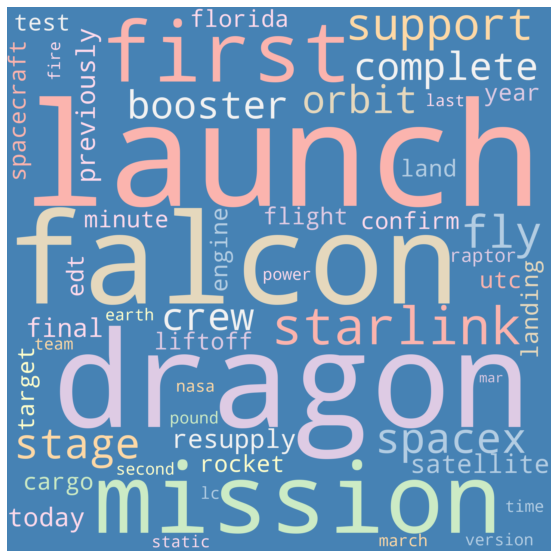

In [52]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/space_x_1st.png", bbox_inches='tight', dpi=600)
plt.show()

## 2nd period

In [53]:
spx2 = spx_df[spx_df.Datetime >= '2020-09-02'][spx_df.Datetime < '2020-10-13']
spx2.shape

<ipython-input-53-ac95be4c331e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spx2 = spx_df[spx_df.Datetime >= '2020-09-02'][spx_df.Datetime < '2020-10-13']


(52, 9)

### Calculate the frequency

In [54]:
#create bag words
all_vid =[]

for item in spx2.filter_tk.to_numpy():
    all_vid += item
    
bag_words = list(set(all_vid))
np.shape(bag_words)

(270,)

In [55]:
bag_words[:10]

['upgrade',
 'mar',
 'water',
 'astronomical',
 'back',
 'starman',
 'propulsive',
 'march',
 'tonight',
 'iss']

In [56]:
bag_words_frequency={} # declare "bag_words_idf" data structure is dictionary 

for word in bag_words:
    bag_words_frequency[word]= all_vid.count(word)

### Visualization

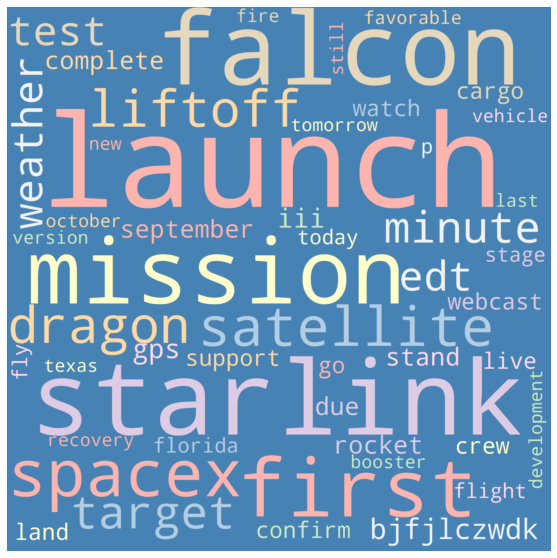

In [57]:
#can set a cutoff by max_words
wc = WordCloud(width = 2000, height = 2000, random_state=1, background_color='steelblue', colormap='Pastel1'
               , collocations=False, stopwords = STOPWORDS
               , max_words=50).generate_from_frequencies(bag_words_frequency)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("pics/space_x_2nd.png", bbox_inches='tight', dpi=600)
plt.show()